# Machine Learning LAB 3: CLUSTERING - K-means and linkage-based clustering

Course 2023/24: *M. Caligiuri*, *P. Talli*, *F. Lincetto*, *F. Chiariotti*, *P. Zanuttigh*

The notebook contains some simple tasks about **CLUSTERING**.

Complete all the **required code sections** and **answer to all the questions**.

### IMPORTANT for the evaluation score:

1. **Read carefully all cells** and **follow the instructions**.
2. **Re-run all the code from the beginning** to obtain the results for the final version of your notebook, since this is the way we will do it before evaluating your notebooks.
3. Make sure to fill the code in the appropriate places **without modifying the template**, otherwise you risk breaking later cells.
4. Please **submit the jupyter notebook file (.ipynb)**, do not submit python scripts (.py) or plain text files. **Make sure that it runs fine with the restat&run all command**.
5. **Answer the questions in the appropriate cells**, not in the ones where the question is presented.

## Image segmentation with k-means

In this laboratory we will use the k-means algorithm to cluster a dataset of 3D points. We will apply **K-means** to the problem of image compression and image segmentation. The main idea is to apply k-means to the colors of the pixels of an image to select the k most representative colors. Then, we will replace each pixel color with the closest representative color. This will allow us to reduce the number of colors in the image and compress it. A color is a vector of 3 values (R,G,B) that represent the amount of red, green and blue in the color; this implies that each pixel is a point in a 3D space.

In particular you are going to implement the k-means algorithm from scratch and to compare the results with the implementation already present in the sklearn library.

In the second part of the laboratory we will use a **linkage-based** clustering algorithm to cluster a dataset of 2D points and compare it with the results obtained with k-means.

---

## Preliminary step

Place your **name** and **ID number** (matricola) in the cell below. <br>
Also recall to **save the file as Surname_Name_LAB02.ipynb**, failure to do so will incur in a **lower grade**.

**Student name**: Gabriele Poccianti

**ID Number**: 2106713

---

## Import all the necessary Python libraries

In [1]:
%matplotlib inline  

import numpy as np
import typing as tp
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from matplotlib import pyplot as plt

import typing as tp
import pandas as pd

---

## Define the heplper functions

In this section you will find some helper functions (some already implemented, some to be implemented by you) that will be used in the following sections.
1. `img_plot` -> function to plot an image with name and dimension as title,
2. `scatter_plot` -> function to plot a scatter plot of the data,
3. `scatter_plot_2d` -> function to plot a 2D scatter plot of the data,
4. `error_plot` -> function to plot the error of the k-means algorithm over the iterations,
5. `cluster_plot` -> function to plot the obtained clusters.

**DO NOT CHANGE THE PRE-WRITTEN CODE UNLESS OTHERWISE SPECIFIED**

In [2]:
def img_plot(img: np.ndarray, title: str = None) -> None:
    """
    Plot an image
    :param img: image to plot
    :param title: title of the plot
    """
    
    plt.figure()
    plt.imshow(img)
    plt.axis('off')
    if title is not None:
        plt.title(f'{title}: {img.shape}')
    plt.tight_layout()
    plt.show()
    plt.close()

In [3]:
def scatter_plot(data: np.ndarray, clusters: np.ndarray = None, centers: np.ndarray = None, title: str = None) -> None:
    """
    Plot a scatter plot of the data
    :param data: data to plot
    :param clusters: cluster labels
    :param centers: cluster centers
    :param title: title of the plot
    """
    
    fig = plt.figure()
    axis = fig.add_subplot(1, 1, 1, projection="3d")
    axis.set_xlabel("Red")
    axis.set_ylabel("Green")
    axis.set_zlabel("Blue", rotation=90, labelpad=-1)
    if title is not None:
        plt.title(title)
    if clusters is None:
        axis.scatter(data[:,0], data[:,1], data[:,2], marker="o", c=data, s=5)
    else:
        axis.scatter(data[:,0], data[:,1], data[:,2], marker="o", c=clusters, s=1, cmap='viridis', zorder=0, alpha=0.5 )
    if centers is not None:
        axis.scatter(centers[:,0], centers[:,1], centers[:,2], c='red', s=400, zorder=10)
    plt.tight_layout()
    plt.show()
    plt.close()

In [4]:
def scatter_plot_2d(x: np.ndarray, y: np.ndarray = None, centers: np.ndarray = None, title: str = None) -> None:
    """
    Plot a scatter plot of the data
    :param x: data to plot
    :param y: cluster labels
    :param centers: cluster centers
    :param title: title of the plot
    """

    fig = plt.figure()
    plt.scatter(x[:,0], x[:,1], c=y, marker="o", s=10, cmap='viridis')
    plt.scatter(centers[:,0], centers[:,1], c='black', s=200, alpha=0.5)
    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

In [5]:
def error_plot(errors: np.ndarray, labels: np.ndarray = None) -> None:
    """
    Plot the errors over the iterations
    :param errors: errors to plot
    """
    
    if labels is None:
        plt.plot(errors[1:-1])
        plt.plot(errors[1:-1], 'ro')
    else:
        plt.plot(labels, errors)
        plt.plot(labels, errors, 'ro')
    plt.title('Error over iterations')
    plt.ylabel('Error')
    plt.xlabel('Iteration #')
    plt.grid()
    plt.tight_layout()
    plt.show()
    plt.close()

In [6]:
def cluster_plot(labels: np.ndarray, x: np.ndarray, title: str = None) -> None:
    """
    Plot the clusters
    :param labels: cluster labels
    :param x: data
    :param title: title of the plot
    """
    
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each)
            for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = x[class_member_mask ]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=14)

        xy = x[class_member_mask ]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                markeredgecolor='k', markersize=6)

    if title is not None:
        plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.close()

---

## A) K-means clustering

### TO DO (A.0)
    
**Set** the random **seed** using your **ID**. If you need to change it for testing add a constant explicitly, eg.: 1234567 + 1

In [7]:
# Fix your ID ("numero di matricola") and the seed for random generator
# as usual you can try different seeds by adding a constant to the number:
# ID = 1234567 + X
ID = 2106713  # insert your ID number here
np.random.seed(ID)

In [8]:
# Load the provided images and display them (if you like you can experiment with other images)
# To load the images use the function plt.imread(<path_to_iamge>)
# ADD YOUR CODE HERE
santa=plt.imread("data/santaclaus2.jpg")
landscape=plt.imread("data/landscape.jpg")
reindeer=plt.imread("data/reindeer.jpg")
# Plot the images with their shapes
# Sugestion: use the function img_plot()
# ADD YOUR CODE HERE
img_plot(santa,"Santa Claus")
img_plot(landscape,"A landscape")
img_plot(reindeer,"reindeers")

ValueError: object __array__ method not producing an array

<Figure size 640x480 with 1 Axes>

ValueError: object __array__ method not producing an array

<Figure size 640x480 with 1 Axes>

ValueError: object __array__ method not producing an array

<Figure size 640x480 with 1 Axes>

We are going to start by using the Santa Claus image.


In [9]:
# Reshape the data to a matrix of num_pixels x 3 
# (divide by 255 to have colors in [0 1] range for plotting functions of sklearn)
# ADD YOUR CODE HERE
label="Santa Claus"
santa2=santa.reshape(santa.shape[0]*santa.shape[1],3)
santa2=santa2/255
# Print the shape of the data and the min and max values of the pixels
# ADD YOUR CODE HERE
print("the shape of the image of Santa Claus is: ")
print(santa2.shape)

the shape of the image of Santa Claus is: 
(44032, 3)


Plot the points in the 3-dimensional space with normalized intervals between 0 and 1 (corresponding to the three channels of the image, i.e. Red Green and Blue)

scatter plot of Santa Claus


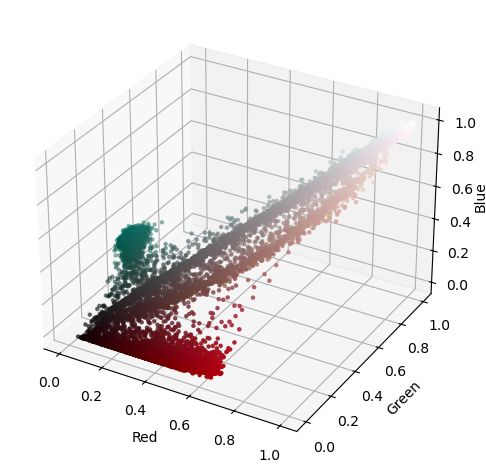

In [22]:
# Sugestion: use the function scatter_plot()
# ADD YOUR CODE HERE
print("scatter plot of Santa Claus")
scatter_plot(santa2)

### TO DO (A.1)
Implement the k-means algorithm manually (**do not use the kmeans function of sklearn and do not download implementations from other web sources**). The inputs to the function is the set of vectors to be clustered and the number of clusters. The output must contain the clusters barycenters, a vector associating each data point to the corresponding cluster and the error (value of the cost function) at each iteration.
Additionally, fix a maximum number of iterations of the k-means algorithm (e.g., 50).

Be careful about the initalization, you can use some random points from the training set, or get random values but ensure they are in the proper range. Poor initalizations can lead to the failure of the algorithm (in particular check that no cluster is initialized as empty, otherwise the algorithm can not update it).

In [24]:
def my_kmeans(points: np.ndarray, k: int, max_iters: int = 50) -> tp.Tuple[np.ndarray, np.ndarray, list]:
    """
    Perform K-means clustering
    :param points: data points
    :param k: number of clusters
    :param max_iters: maximum number of iterations
    """

    # Generate random centers
    # use sigma and mean to ensure it represent the whole data
    # ADD YOUR CODE HERE    

    centroids = []
    
    for i in range(k):
        idx = np.random.randint(0, points.shape[0])
        centroids.append(points[idx])
    
    centroids = np.array(centroids)  # This way, the centers list is a numpy array
  
    prev_error = 100000
    error = [9999]
    
    # Iterate until the estimate of that center stays the same or max iteration are reached
    iters = 0

    d = metrics.DistanceMetric.get_metric('euclidean')   # I use the standard euclidean distance
    
    while (error[iters] != prev_error) and iters < max_iters:
        # Measure the distance to every center
        # ADD YOUR CODE HERE
        dist_pair = d.pairwise(points, centroids) ** 2

        # Assign all training data to closest center
        # ADD YOUR CODE HERE
        clusters = np.argmin(dist_pair, axis = 1) 
       
        # Calculate mean for every cluster and update the center
        # Filter the points based on which cluster they're closer to:
        # ADD YOUR CODE HERE
        idx0 = np.where(clusters == 0)[0]                     
        idx1 = np.where(clusters == 1)[0]                     
        idx2 = np.where(clusters == 2)[0]                     
        
        # Update the centers and calculate the distances
        # ADD YOUR CODE HERE
        sigma = np.array([0., 0., 0.])
        d_0 = 0.
        for i in range(len(idx0)):
            d_0 += (points[idx0[i]][0] - centroids[0][0]) ** 2 + (points[idx0[i]][1] - centroids[0][1]) ** 2 + (points[idx0[i]][2] - centroids[0][2])**2
            sigma += points[idx0[i]]
        centroids[0] = sigma / len(idx0)
        
        sigma = np.array([0., 0., 0.])
        d_1 = 0.
        for i in range(len(idx1)):
            d_1 += (points[idx1[i]][0] - centroids[1][0]) ** 2 + (points[idx1[i]][1] - centroids[1][1]) ** 2 + (points[idx1[i]][2] - centroids[1][2])**2
            sigma += points[idx1[i]]
        centroids[1] = sigma / len(idx1)
        
        sigma = np.array([0., 0., 0.])
        d_2 = 0.
        for i in range(len(idx2)):
            d_2 += (points[idx2[i]][0] - centroids[2][0]) ** 2 + (points[idx2[i]][1] - centroids[2][1]) ** 2 + (points[idx2[i]][2] - centroids[2][2])**2
            sigma += points[idx2[i]]
        centroids[2] = sigma / len(idx2)
        
        
        # Update the error
        # ADD YOUR CODE HERE
        cost = d_0 + d_1 + d_2
        error.append(cost)
        prev_error = error[iters]
        
        # Update the iteration counter
        iters += 1

    return centroids, clusters, error

### TO DO (A.2)

Now try the function you developed on the Santaclaus image with three clusters (k=3). 

Then plot the data points in the 3-dimensional space, each point must be coloured based on the membership to one of the clusters. Additionally, plot the respective clusters centroids (use a different shape, size or color to highlight the centroids).

[9999, 2761.0096116877894, 1145.9989400098736, 1095.69783254905, 1093.180995357197, 1092.9579575938487, 1092.9038957980508, 1092.8789106971074, 1092.8766897438168, 1092.8765497482486, 1092.8765497482486]


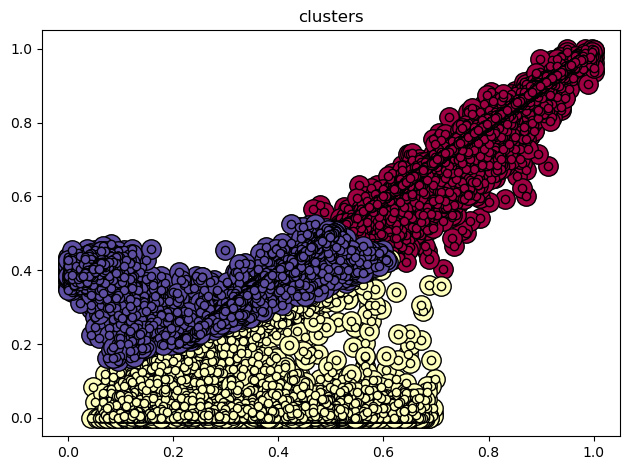

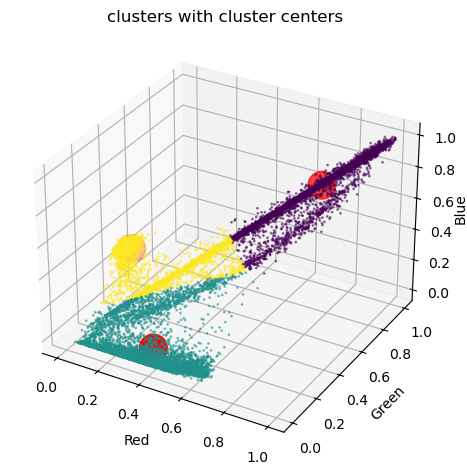

In [26]:
# Run your K-means function on the data
# ADD YOUR CODE HERE
def safe_int_convert(x):
    try:
        return int(float(x))
    except (ValueError, TypeError):
        return 0  # or some other default value

k=3
centr,clust,err=my_kmeans(santa2,k,50)

data=santa2
lab=clust
# Apply the conversion function to each element in the array
lab = np.array([safe_int_convert(x) for x in lab], dtype=np.int32)

# Print the errors:
# ADD YOUR CODE HERE
print(err)

# Plot the results
# ADD YOUR CODE HERE
cluster_plot(lab,data,"clusters")
scatter_plot(data,lab,centr,"clusters with cluster centers")

### TO DO (A.3) 
Plot the value of the error versus the number of iterations

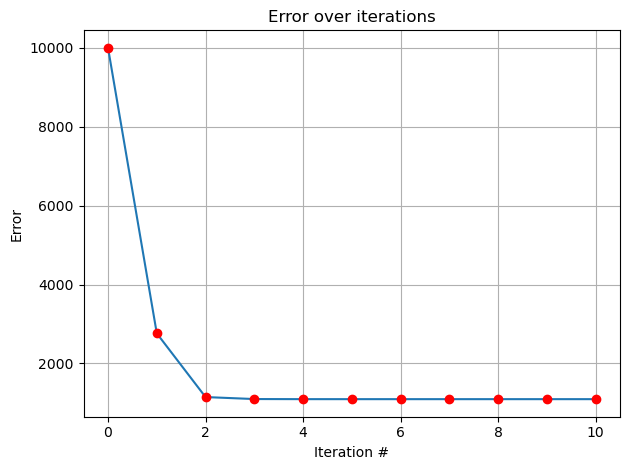

In [28]:
# Sugestion: use the function error_plot()
# ADD YOUR CODE HERE
error_plot(err,np.arange(len(err)))

### TO DO (A.4)
Now use the k-means function provided in sklearn. Pass to the function the number of clusters and use multiple random initializations (n_init parameter). Go to the documentation page for further details

In [30]:
# Define the K-means model
# ADD YOUR CODE HERE
K_santa=KMeans(n_clusters=3,init="random",n_init=300,max_iter=50)
# Fit the model to the data
# ADD YOUR CODE HERE
K_santa=K_santa.fit(santa2)
# Get the cluster centers
# ADD YOUR CODE HERE
labels=K_santa.predict(santa2)
err=K_santa.inertia_
centers=K_santa.cluster_centers_
c_lab=K_santa.predict(centers) #centers' labels

Perform the same plot as above but with the output of the k-means function provided in sklearn.

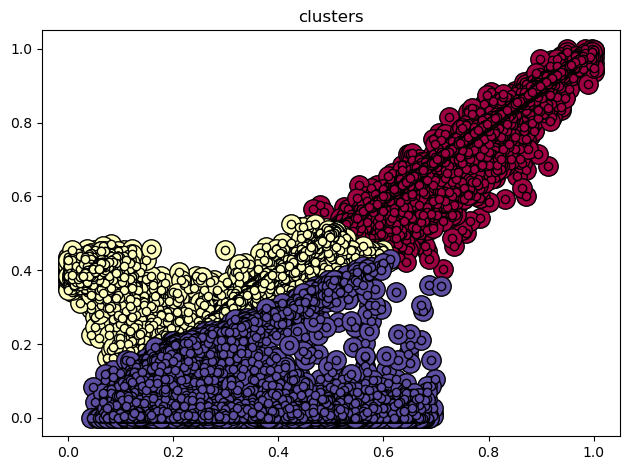

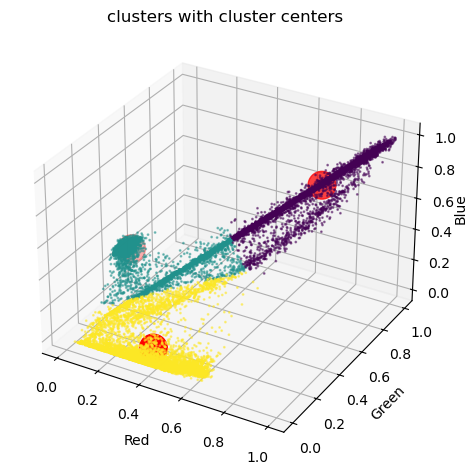

final error: 1092.876745628536


In [32]:
# ADD YOUR CODE HERE
cluster_plot(labels,santa2,"clusters")
scatter_plot(santa2,labels,centr,"clusters with cluster centers")
print("final error: "+str(err))

### TO DO (A.Q1) [Answare the following] 

Compare the results obtained with your implementation and with k-means from sklearn. Do you observe any differences, *i.e.*, do the two plots match?

**ANSWER A.Q2:** We can observe that the barycenter and most of the clusters obtained with my implementation of the Llyod algorithm and the sklearn implementation match. We can observe that the clusters' labels are different, but this is natural for an unsupervised learning algorithm.

### TO DO (A.5)

Now display the segmented image based on the two clusters found above with the k-means functions by sklearn.

In [36]:
santa3=santa2

In [37]:
def recolor(image,k,labels): #image in a vector form, number of clusters, centers' labels
    c_col=[]
    image_copy=np.copy(image)
    for i in np.arange(k):
        c_col.append(image[np.where(labels==i)[0][0]])
        image_copy[np.where(labels==i)]=c_col[i]*np.ones((np.array(np.where(labels==i)).shape[1],3))
    return(image_copy)

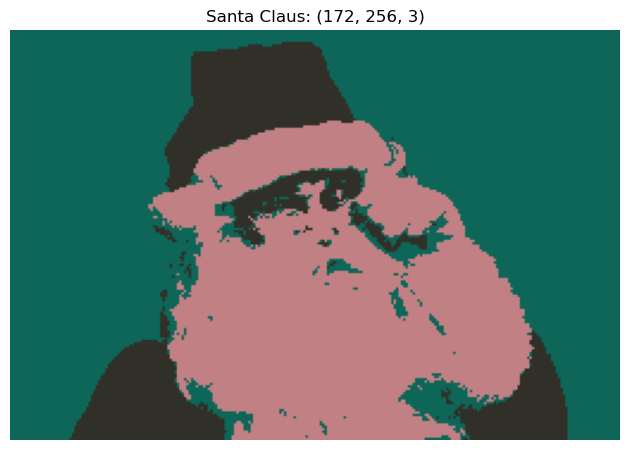

In [38]:
# Extract the color values of the centers
# ADD YOUR CODE HERE
santa2=recolor(santa2,k,labels)

# Reshape the data to the original image shape
# ADD YOUR CODE HERE
santa2=santa2.reshape(santa.shape)
# Plot the recolored image
# ADD YOUR CODE HERE
img_plot(santa2,"Santa Claus")

In [39]:
#da eliminare
data_old=data

In [40]:
#da eliminare
data=data_old

Now display the segmented image based on the two clusters found above with the k-means functions implemented by yourselves.

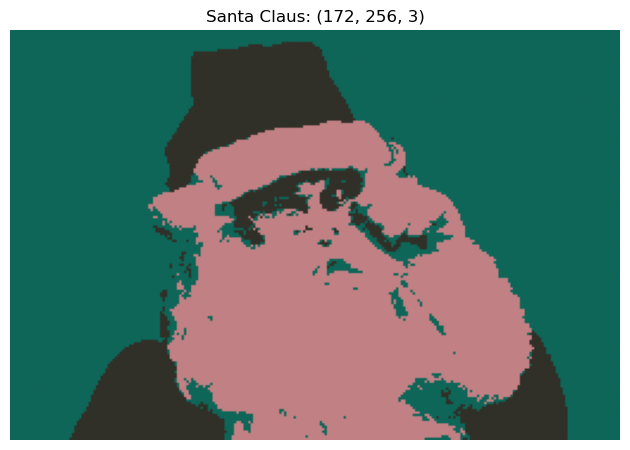

In [42]:
# Extract the color values of the centers
# ADD YOUR CODE HERE
data=recolor(data,k,lab)

# Reshape the data to the original image shape
# ADD YOUR CODE HERE
data=data.reshape(santa.shape)
# Plot the recolored image
# ADD YOUR CODE HERE
img_plot(data,"Santa Claus")

### TO DO (A.Q2) [Answare the following]

What do you observe? Do you think clustering is useful for image segmenation? And for image compression? Comment your answer.

**ANSWER A.Q1:** I observe that the two methods produce almost identical images and they reproduce the image quite well, meaning that k=3 was a good choise (for our purpose)     .
I think that clustering is very useful for image sementation since, as we can see in our case, the main element of the image remain distinugishable, while the image complexity has been drammatically reduced (so we succesfully compressed the image). This could be applied to image compression, although decompression could be hard.

### TO DO (A.6)

Now load the landscape image (optional: try also with the reindeer image) and segment it using kmeans with k varying from 2 to 15 clusters. You can use the sklearn implementation.

Then plot the resulting data points in the 3-dimensional space, each point must be colored based on the cluster membership.

In [46]:
def recolor(image,k,c_lab,labels): #image in a vector form, number of clusters, centers' labels
    c_col=[]
    image_copy=np.copy(image)
    for i in np.arange(k):
        c_col.append(image[np.array(np.where(labels==c_lab[i]))[0]])
        image_copy[np.where(labels==i)]=c_col[i][0]*np.ones((np.array(np.where(labels==i)).shape[1],3))
    return(image_copy)

the shape of the landscape image is:
(19200, 3)
For the R component the min value is 1 and the max is 116
For the G component the min value is 2 and the max is 118
For the B component the min value is 3 and the max is 119

K-means clustering with different values of K (2-15):


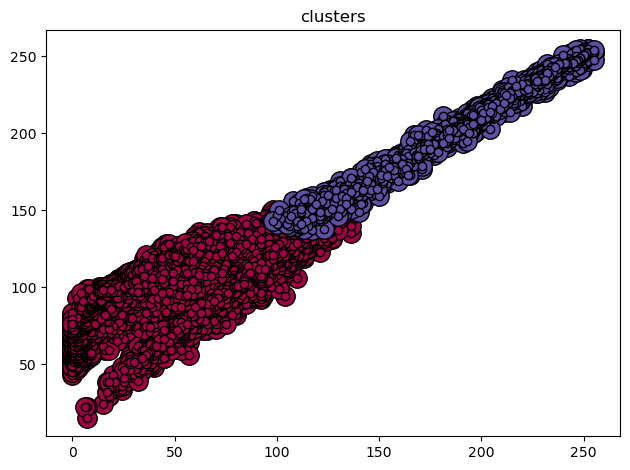

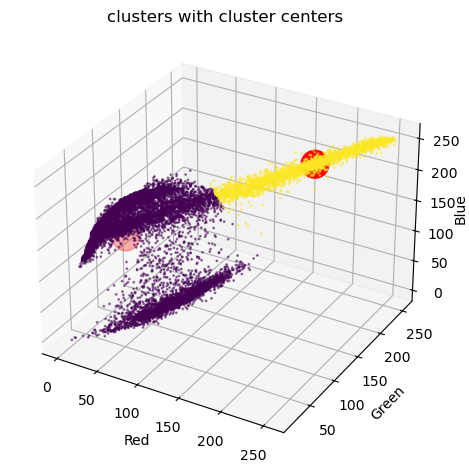

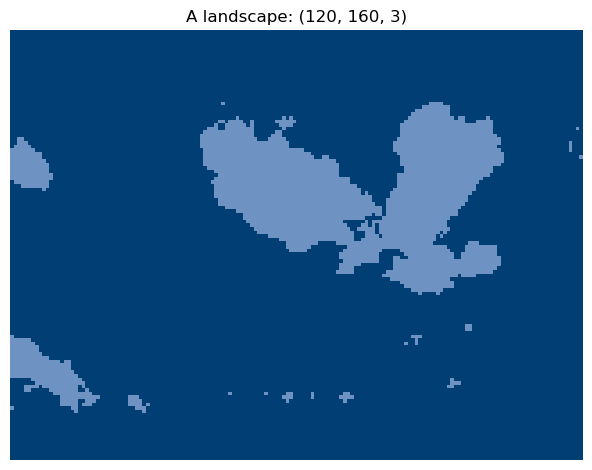

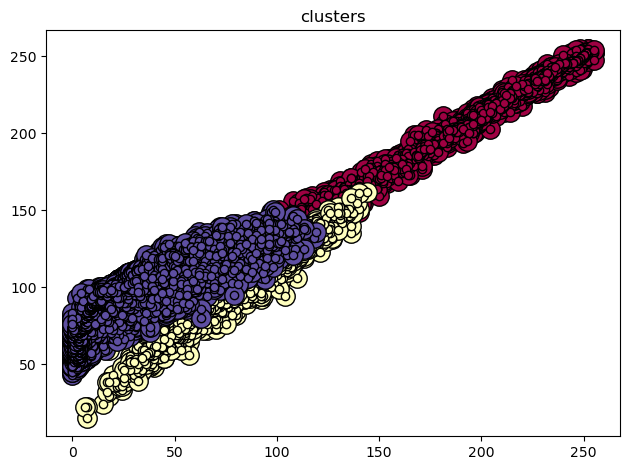

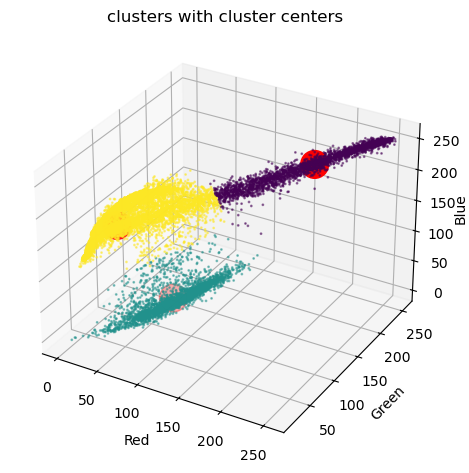

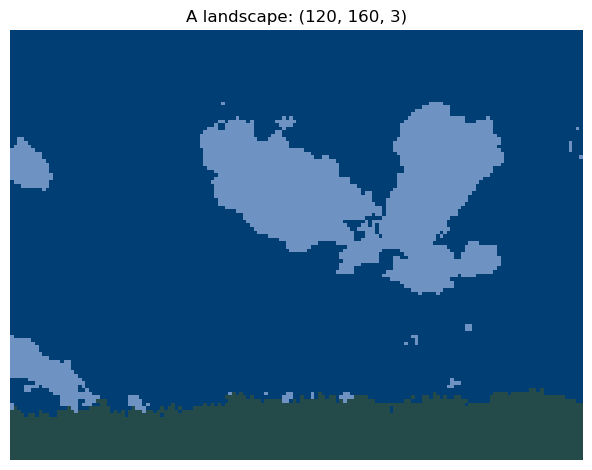

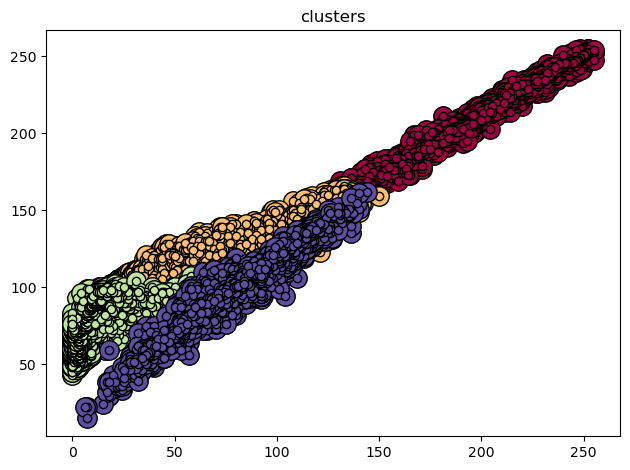

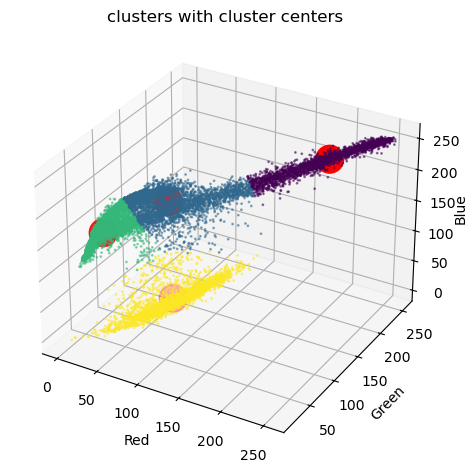

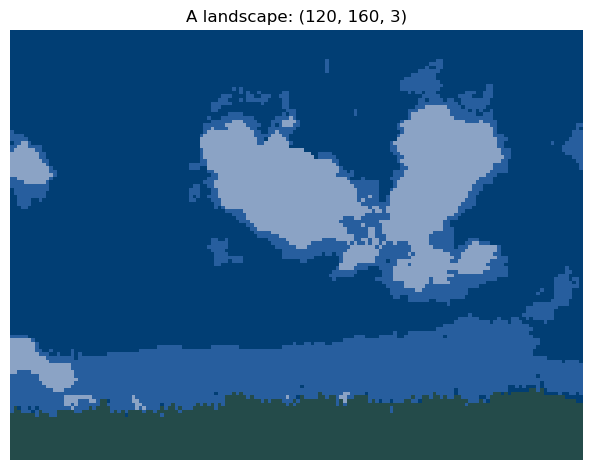

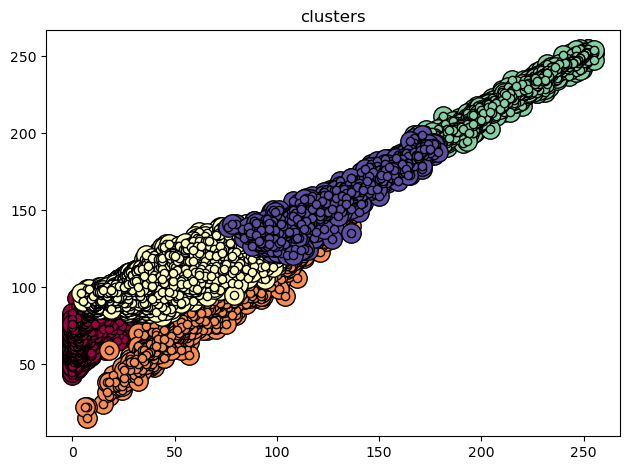

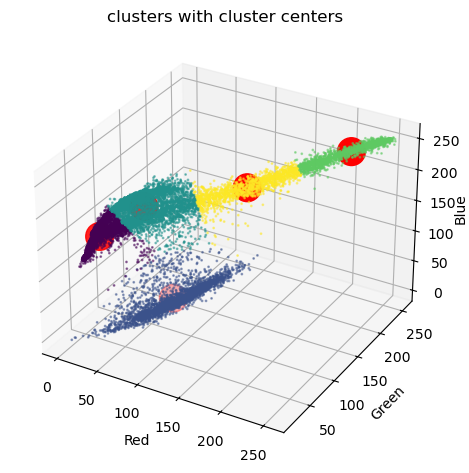

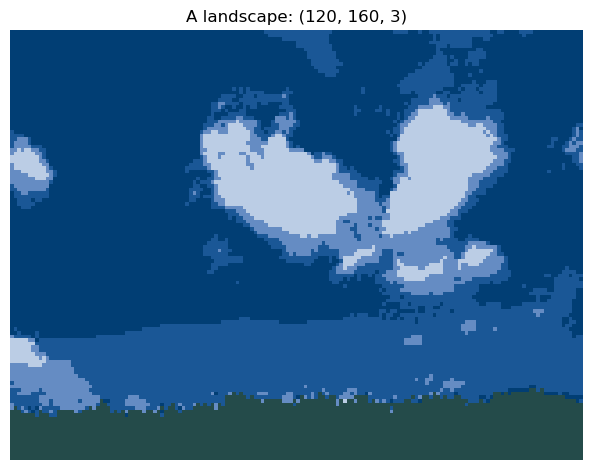

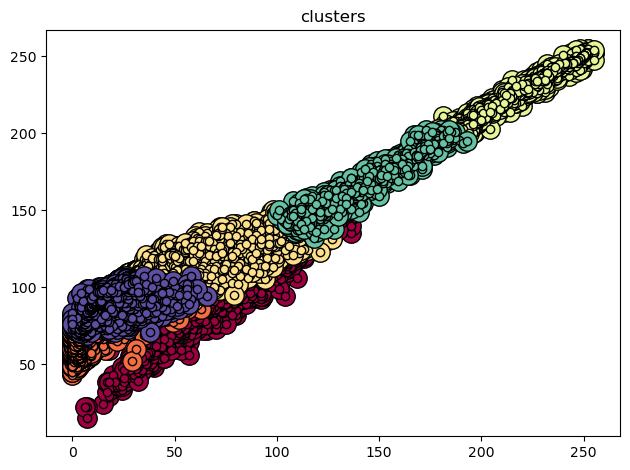

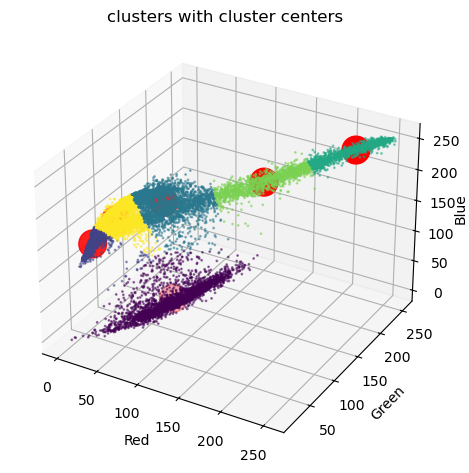

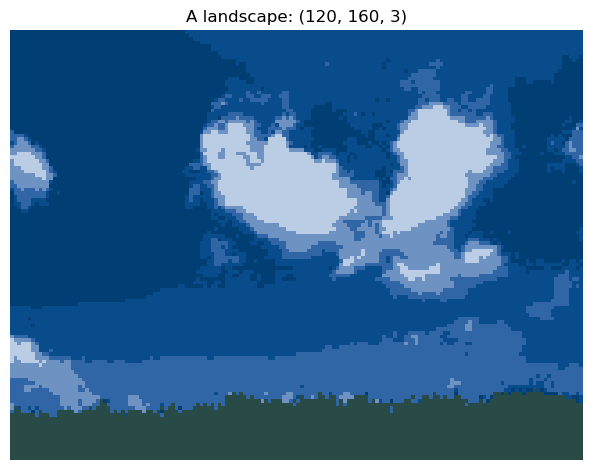

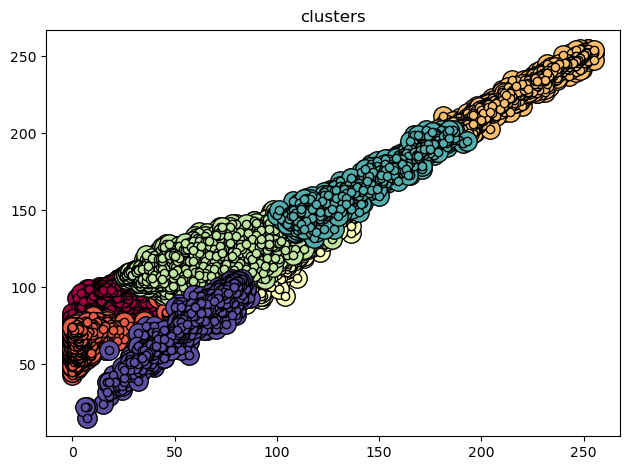

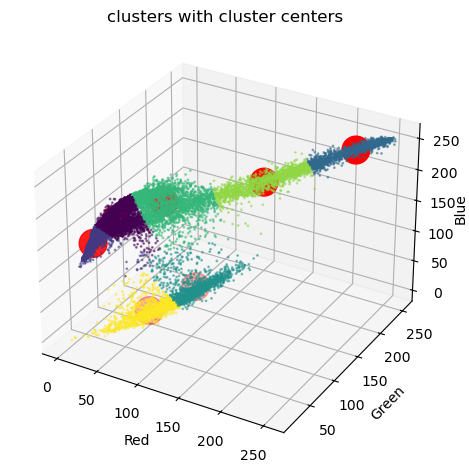

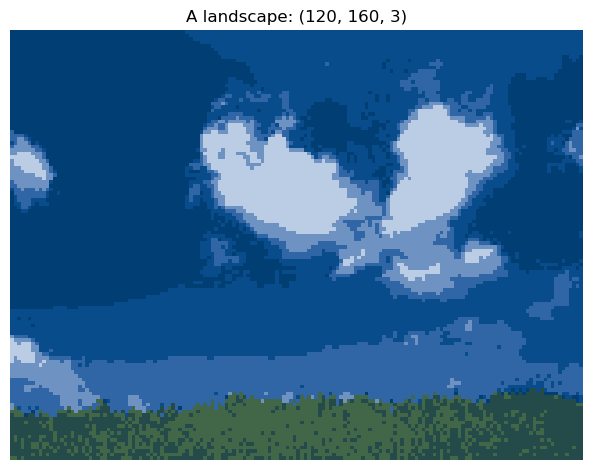

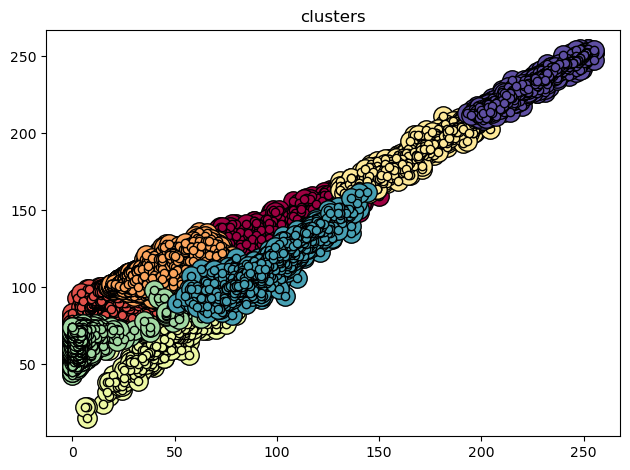

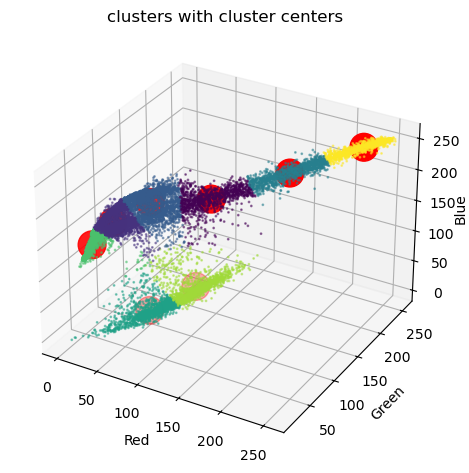

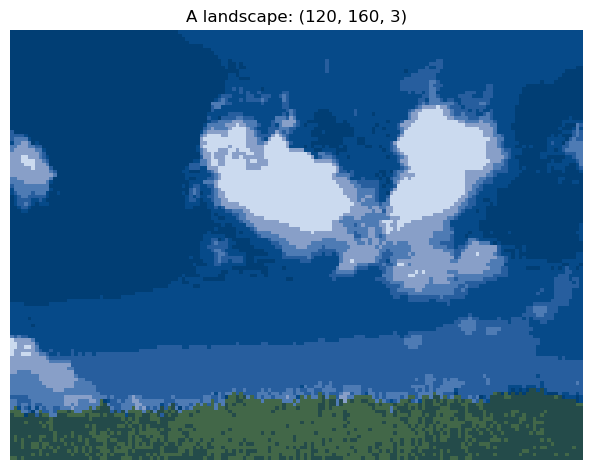

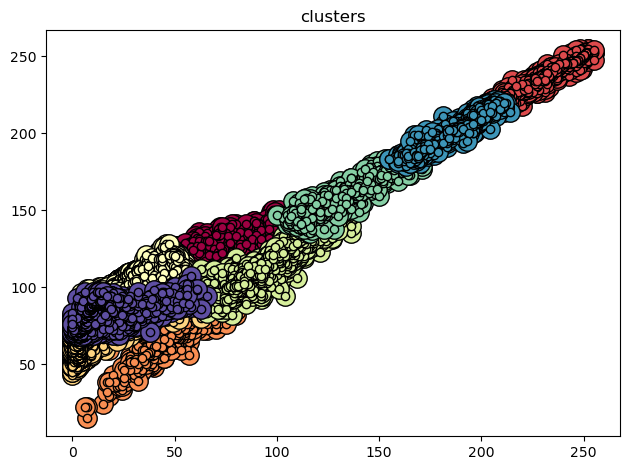

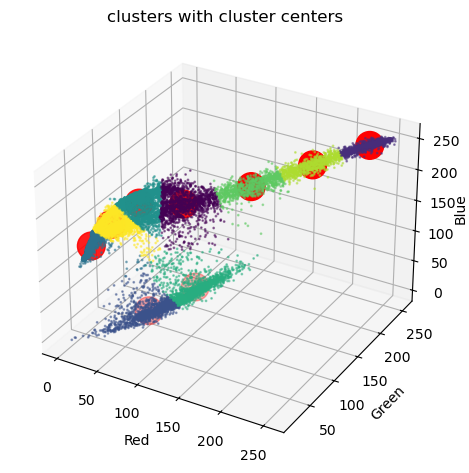

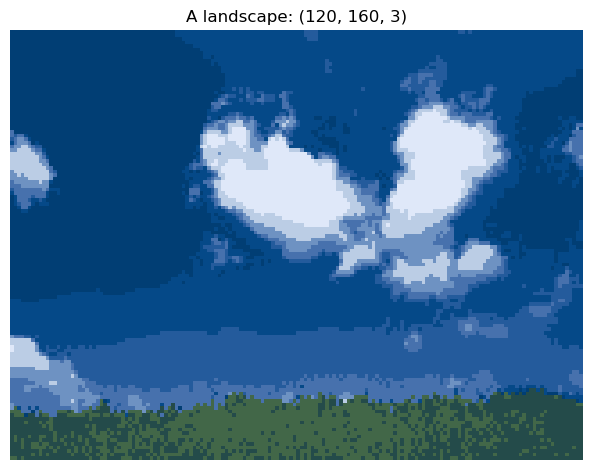

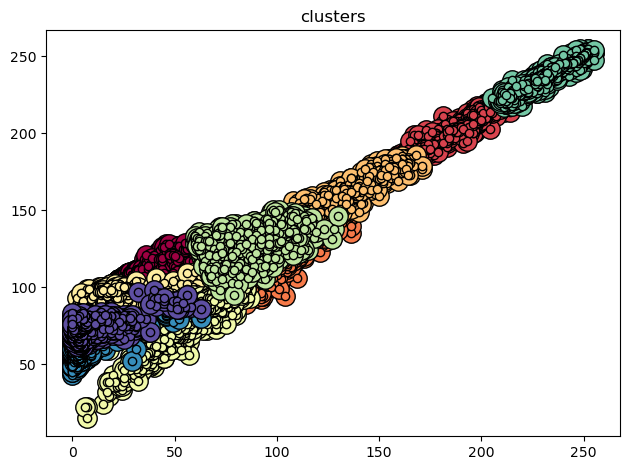

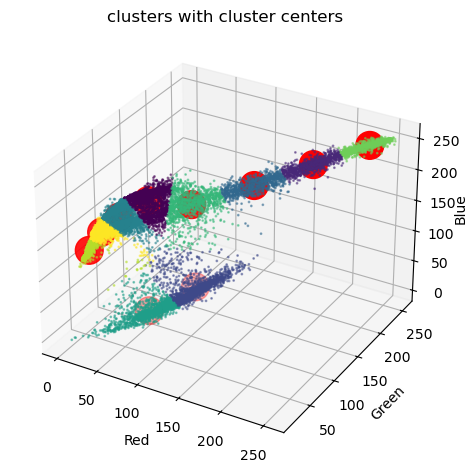

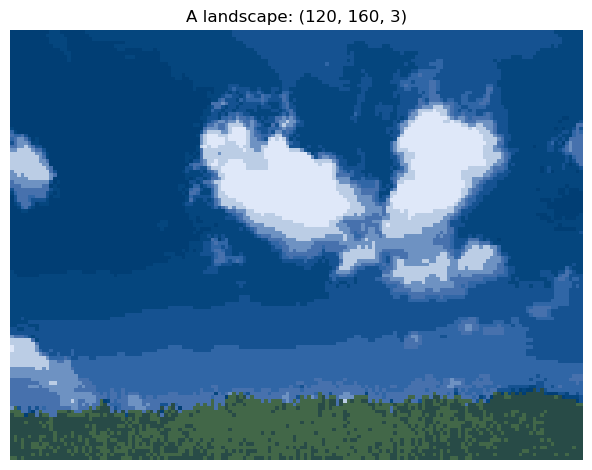

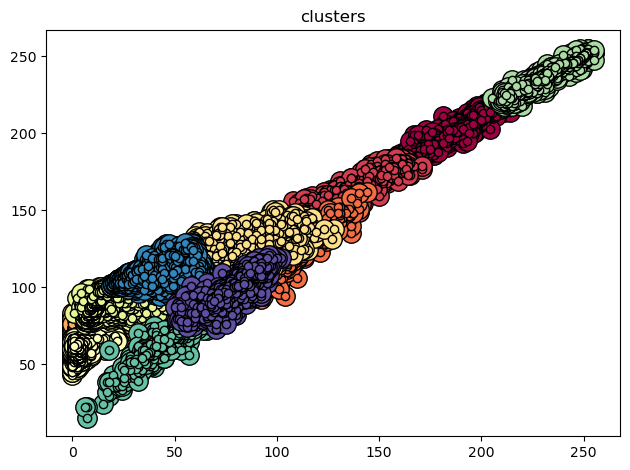

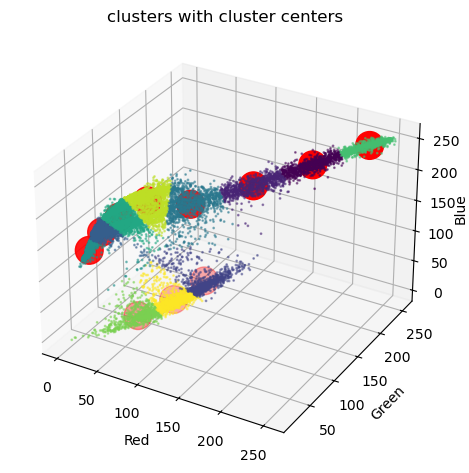

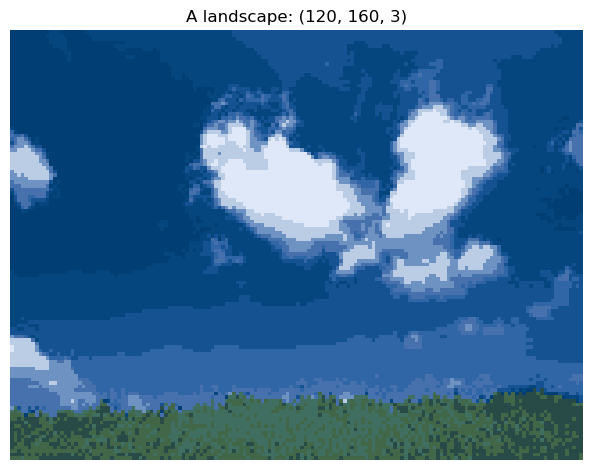

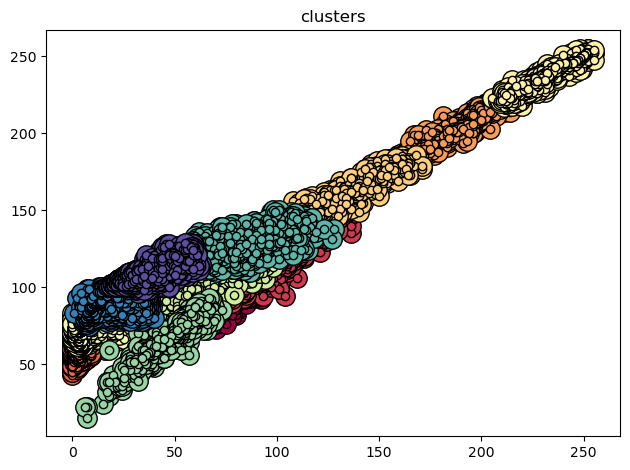

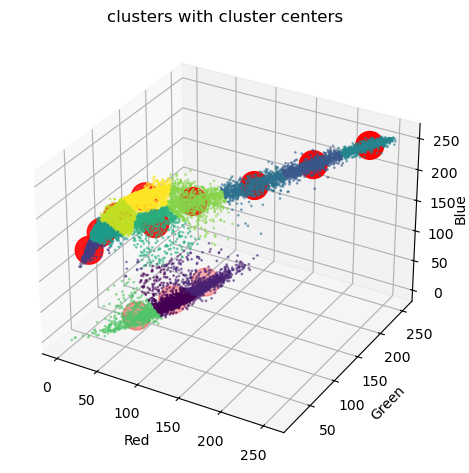

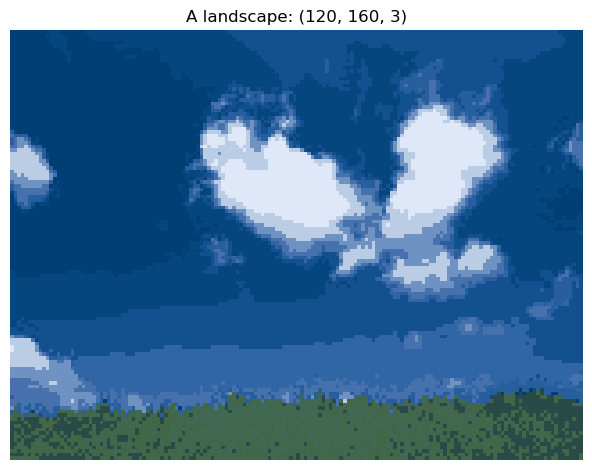

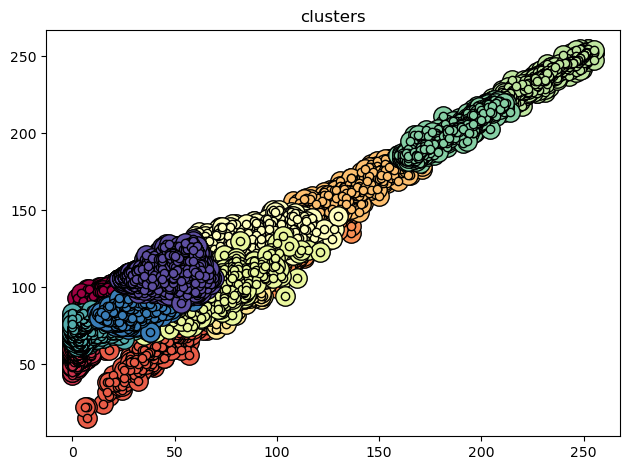

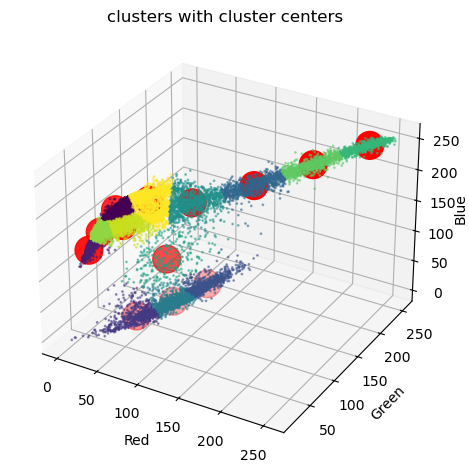

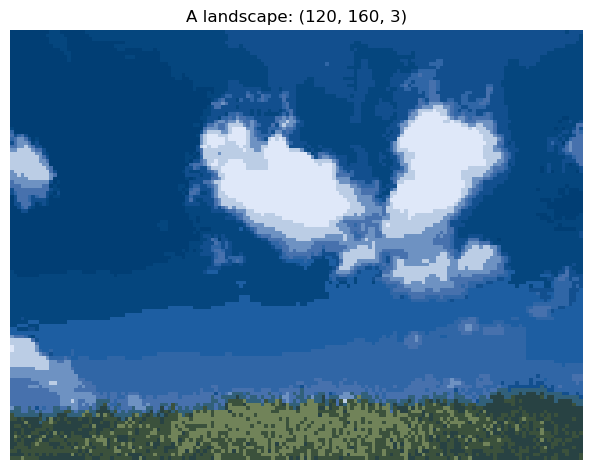

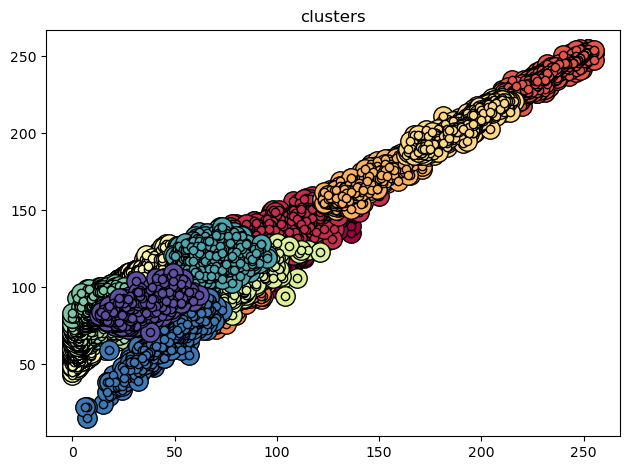

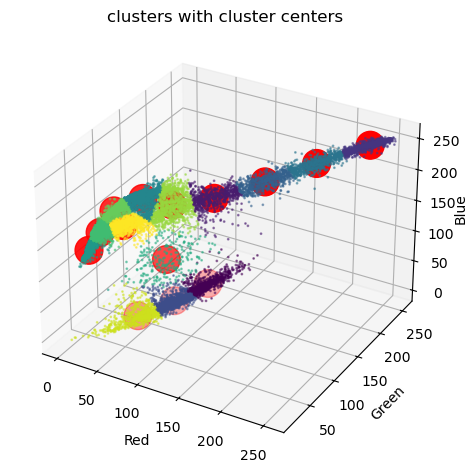

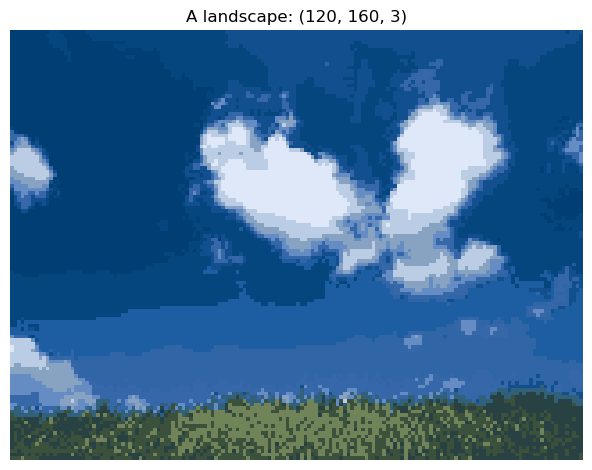

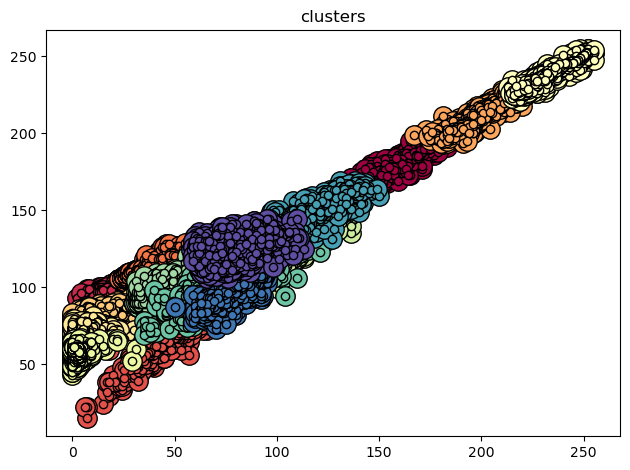

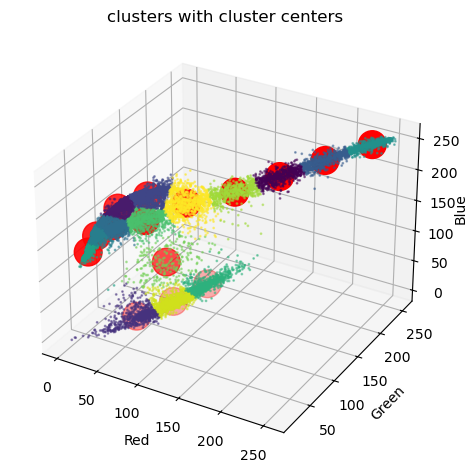

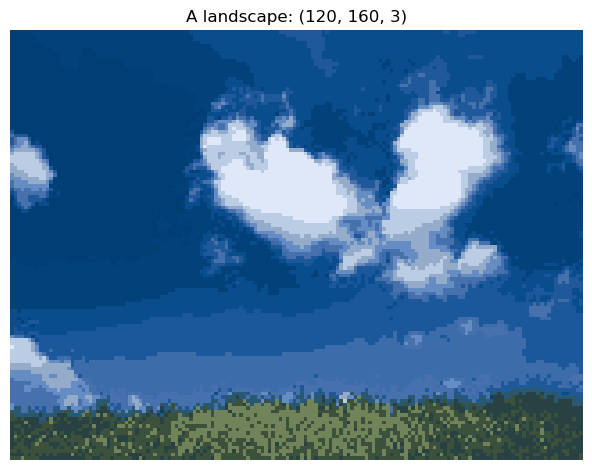

In [47]:
# Reshape the data to a matrix of total_num_pixels x 3
# ADD YOUR CODE HERE
landscape2=np.array(landscape.reshape(landscape.shape[0]*landscape.shape[1],3))

# Print the shape of the data and the min and max values of the pixels
# ADD YOUR CODE HERE
print("the shape of the landscape image is:")
print(landscape2.shape)
print("For the R component the min value is {}".format(min(landscape2[0]))+" and the max is {}".format(max(landscape2[0])))
print("For the G component the min value is {}".format(min(landscape2[1]))+" and the max is {}".format(max(landscape2[1])))
print("For the B component the min value is {}".format(min(landscape2[2]))+" and the max is {}".format(max(landscape2[2])))

# Cycle over different values of K and plot the results for each value
error=[]
print('\nK-means clustering with different values of K (2-15):')
inertia = list()
for k in range(2,16):
    # Define the K-means model
    # ADD YOUR CODE HERE
    K_l=KMeans(n_clusters=k,init="random",n_init=300,max_iter=50)
    
    # Fit the model to the data
    # ADD YOUR CODE HERE
    K_l=K_l.fit(landscape2)
    
    # Get the cluster centers
    # ADD YOUR CODE HERE
    centers=K_l.cluster_centers_
    labels=K_l.predict(landscape2)
    
    # Extarct the color values of the centers
    # ADD YOUR CODE HERE
    c_lab=K_l.predict(centers)
    landscape3=recolor(landscape2,k,c_lab,labels)

    # Reshape the data to the original image shape
    # ADD YOUR CODE HERE
    landscape_recol=np.array(landscape3.reshape(landscape.shape))
    # Update the inertia
    # ADD YOUR CODE HERE
    error.append(K_l.inertia_)
    # Plot the scatter plot and the ricolored imag
    # ADD YOUR CODE HERE
    cluster_plot(labels,landscape2,"clusters")
    scatter_plot(landscape2,labels,centers,"clusters with cluster centers")
    # Plot the recolored image
    # ADD YOUR CODE HERE (remove the pass statement)
    img_plot(landscape_recol,"A landscape")

### TO DO (A.7)

Plot for different values of k (e.g. k between 2 and 15) the respective error of the kmeans algorithm 

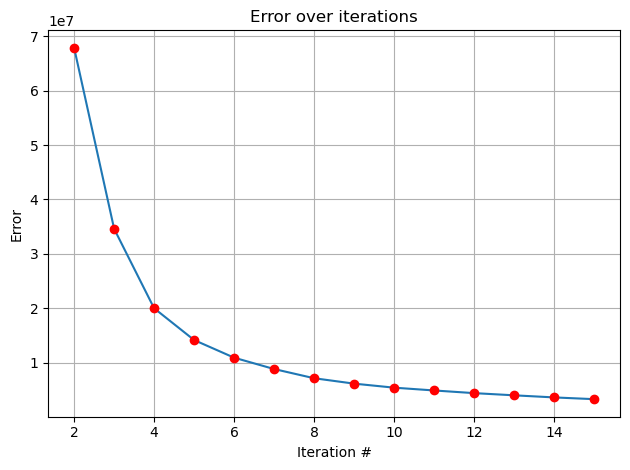

In [49]:
# ADD YOUR CODE HERE
error_plot(error,np.arange(2,16))

### TO DO (AQ.3) [Answare the following]

Compare the results with different values of k, what do you observe? 

Analyze also the error, which one do you think is the optimal value of k?

Is there a single, clear answer?

**ANSWER A.Q3:** We can observe that the error in monotonically decreasing with the number of clusters k.
However we have a net decrease with the first few iteration (2-3) and then the accurancy tends to stabilize, while the risk of overfitting increases.
We could therefore say that the optimal value of k is around 6, altough there is not a clean answer since different k may be useful in different applications, depending the number of details we want to distinguish in an image.

---

## B) Linkage-based clustering

The second part of the assignment concern instead linkage-based clustering. We will use the AgglomerativeClustering module of sklearn. 

### TO DO (B.0)

Load the sample dataset located at `data/moon_data.npz`

In [55]:
# Load sample data
data = np.load("data/moon_data.npz") # ADD YOUR CODE HERE (use np.load())

# Extract data
x = data['X']
labels_true = data['labels_true']

### TO DO (B.1)

Now exploit the AgglomerativeClustering algorithm from the sklearn library on the provided sample data points. Use the "single" linkage type that correspond to the minimum distance criteria seen in the lectures and 2 clusters. Notice that the "single" option has been introduced recently in sklearn, if you get an error ensure you have a recent version of the library. Plot the resulting clustering.

In [57]:
# Compute Agglomerative Clustering
# Define the Agglomerative Clustering model
# ADD YOUR CODE HERE
AC=AgglomerativeClustering(n_clusters=2,linkage='single')
# Fit the model to the data
# ADD YOUR CODE HERE
AC_moon=AC.fit(x)
# Compute the number of clusters in labels, ignoring noise if present.
# ADD YOUR CODE HERE
labels=AC_moon.labels_
n=len(x)
nc1=np.array(np.where(labels==0)).shape[1]
nc2=n-nc1
# Print the results
# ADD YOUR CODE HERE
print("the number of points in the first cluster is {}".format(nc1))
print("the number of points in the second cluster is {}".format(nc2))

the number of points in the first cluster is 750
the number of points in the second cluster is 750


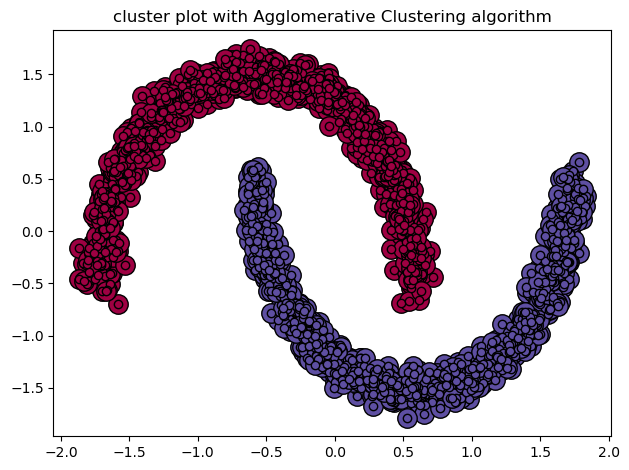

the error with this algorithm is 0.0


In [58]:
# Plot result 
# Sugestion: use the function cluster_plot()
# ADD YOUR CODE HERE
cluster_plot(labels,x,"cluster plot with Agglomerative Clustering algorithm")
err1=sum(abs(labels-labels_true))/n
print("the error with this algorithm is {}".format(err1))

### TO DO (B.2)

Now try the KMeans with two clusters on the same dataset we used for the AgglomerativeClustering algorithm.

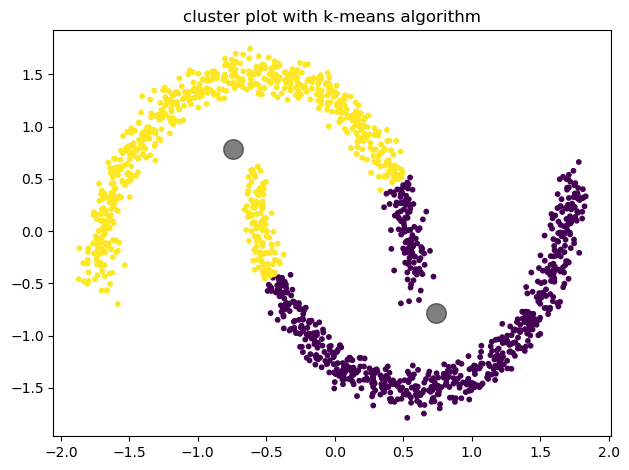

the error with this algorithm is 0.15533333333333332


In [60]:
# Define the K-means model
# ADD YOUR CODE HERE
K_moon=KMeans(n_clusters=2,init="random",n_init=300,max_iter=50)
# Fit the model to the data
# ADD YOUR CODE HERE
K_moon.fit(x)
labels=K_moon.predict(x)
# Get the cluster centers
# ADD YOUR CODE HERE
clc=K_moon.cluster_centers_
# Extract the color values of the centers
# ADD YOUR CODE HERE
clc_col=K_moon.predict(clc)
# Plot the results
# Sugestion: use the function scatter_plot_2d()
# ADD YOUR CODE HERE
scatter_plot_2d(x,labels,clc,"cluster plot with k-means algorithm")
err2=sum(abs(labels-labels_true))/n
print("the error with this algorithm is {}".format(min(err2,1-err2)))

### TO DO (B.Q1) [Answare the following]

Compare the results of K-means and Agglomerative Clustering and explain what you observe and why?

**ANSWER B.Q1:** We observe that for this image the result with AgglomerativeClustering algorithm produces a lower error (calculated as the fraction of misclassified samples) than that obtained from the K-means. We can interprete this phenomena by looking at the distribution of points in the feature space: we can distinguish two seaparate clusters, but some points of one is very close to the center of the other and this conformation reduces the accuracy of the k-means algorithm.

---